[*********************100%***********************]  1 of 1 completed


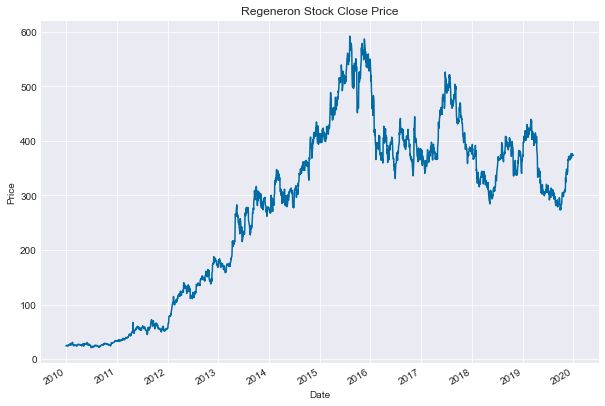

[*********************100%***********************]  1 of 1 completed


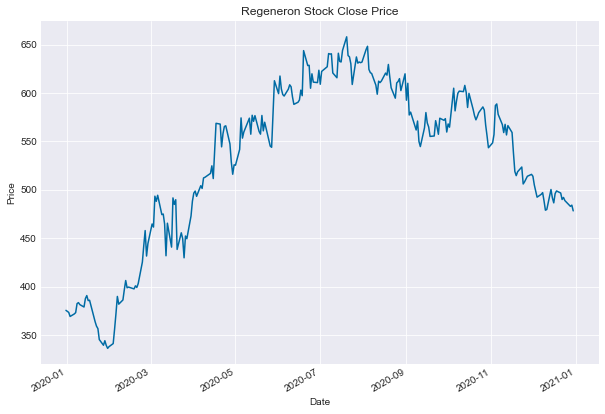

[*********************100%***********************]  1 of 1 completed


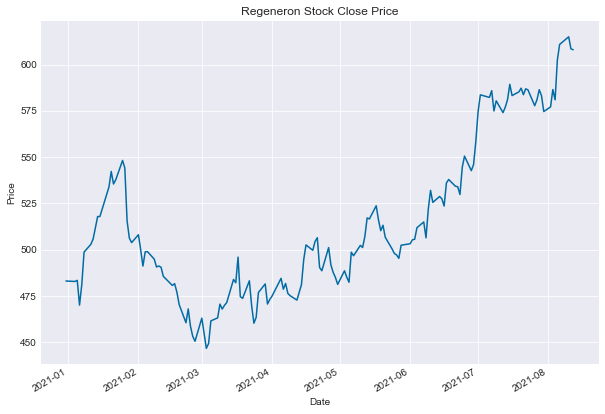

In [16]:
# для запуска файла требуется прописать в командной строке следующие команды:
# pip install pandas
# pip install numpy
# pip install yfinance
# pip install matplotlib
# pip install ta

import pandas as pd #для работы с таблицами
import numpy as np #для математических операций
import yfinance as yf #для выгрузки котировок
import seaborn as sns #для визуализации
import matplotlib.pyplot as plt #для визуализации
import ta #для подсчета эксп. скользящих средних
%matplotlib inline
plt.style.use('tableau-colorblind10')
#Выгружаем данные с Yahoo Finance и строим график стоимости акции:

#За 10 лет
train = yf.download('REGN', start='2010-01-01', end='2019-12-31')
train['Close'].plot(figsize=(10,7))
plt.title('Regeneron Stock Close Price')
plt.ylabel('Price')
plt.show()

#За 2020 год
test = yf.download('REGN', start='2020-01-01', end='2020-12-31')
test['Close'].plot(figsize=(10,7))
plt.title('Regeneron Stock Close Price')
plt.ylabel('Price')
plt.show()

#С января по 13 августа 2021г.
final = yf.download('REGN', start='2021-01-01', end='2021-08-13')
final['Close'].plot(figsize=(10,7))
plt.title('Regeneron Stock Close Price')
plt.ylabel('Price')
plt.show()

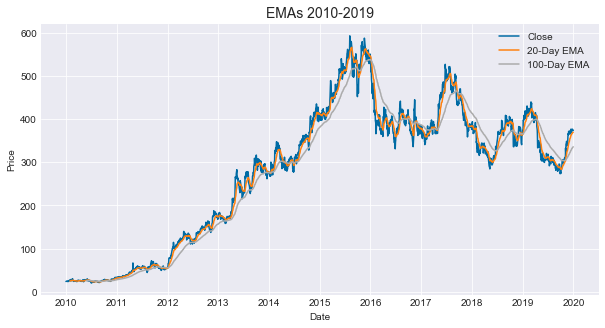

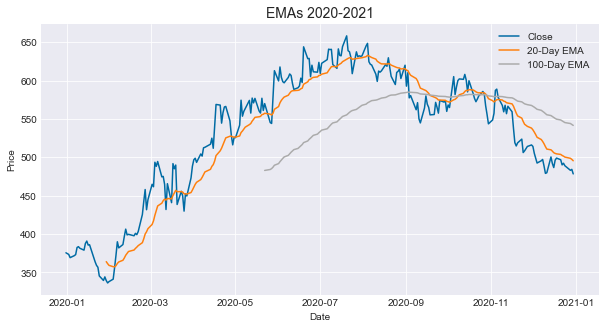

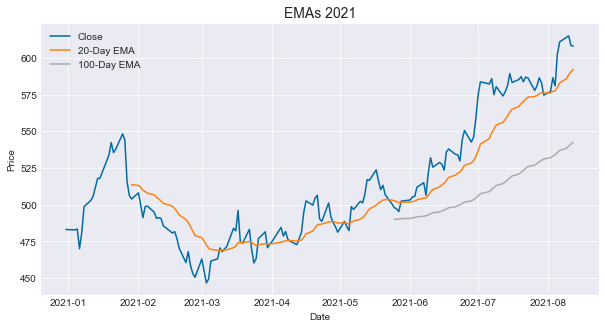

In [17]:
#Создаем функцию, которая добавляет значения скольщих в таблицу с данными об акции
def ema_add(dataset, title):
    
    dataset['short_ema'] = ta.trend.ema_indicator(dataset['Close'], window = 20, fillna = False).T #добавляем быструю скользящую в таблицу (посчитана с помщью библиотеки ta)

    dataset['long_ema'] = ta.trend.ema_indicator(dataset['Close'], window = 100, fillna = False).T #добавляем медленную скользящую в таблицу (посчитана с помщью библиотеки ta)

# Cтроим графики цен закрытия и скользящих средних
    plot_data = dataset[:]
    plt.figure(figsize=(10, 5))
    plt.title('EMAs ' + title, fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Price')

    plt.plot(plot_data['Close'], label='Close')
    plt.plot(plot_data['short_ema'], label='20-Day EMA')
    plt.plot(plot_data['long_ema'], label='100-Day EMA')

    plt.legend()

#применяем функцию на все наши данные    
ema_add(train, '2010-2019')
#train

ema_add(test, '2020-2021')    
#test    
    
ema_add(final, '2021')
#final

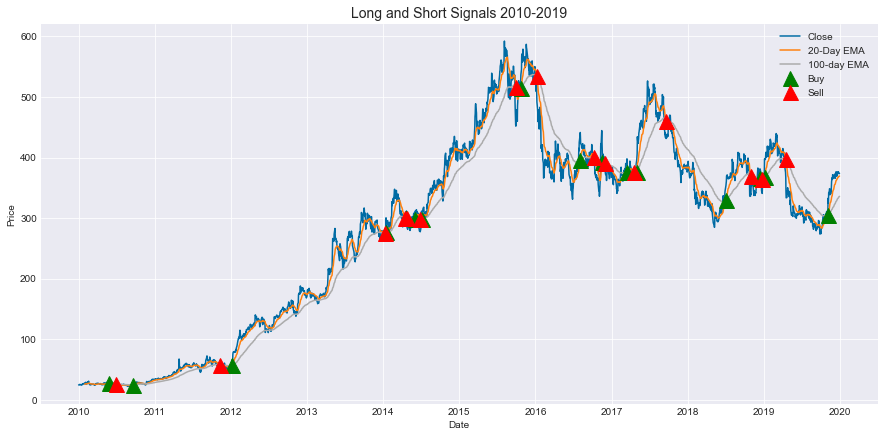

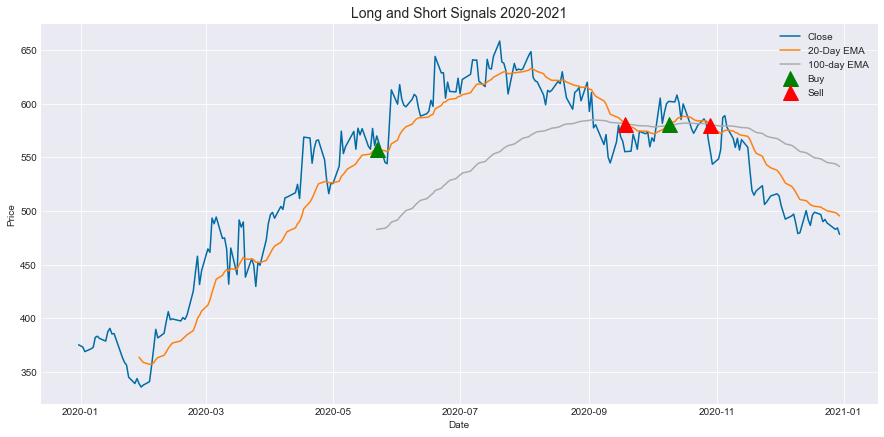

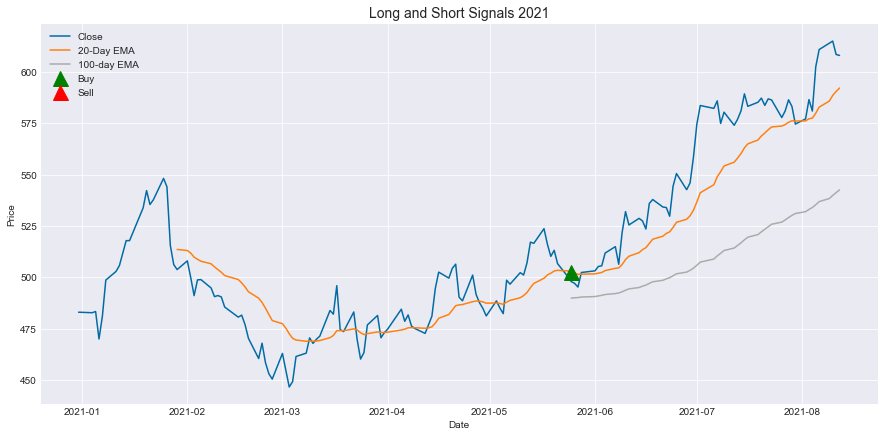

In [18]:
# Создаем функцию, которая открывает позиции на бирже 
def position(dataset, title):
    
    #позициия в лонг (открывается, когда быстрая скользящая пересекает снизу вверх медленную) (первая позиция открывается сразу же)
    dataset['long'] = np.where(dataset['short_ema'] > dataset['long_ema'], 1, 0)

    #позициия в шорт (открывается, когда медленная скользящая пересекает снизу вверх быструю)
    dataset['short'] = np.where(dataset['short_ema'] < dataset['long_ema'], -1, 0)

    # При торговле в шорт, лонг позиция сразу закрывается (и наоборот)
    # Создаем столбец (positions), отвечающий за наличие акции в портфеле (1 - есть, 0 - нет, -1 - шорт позиция)
    dataset['positions'] = dataset['long'] + dataset['short'] 

    # Строим графики покупки/продажи
    plot_data = dataset[:]
    plt.figure(figsize=(15, 7))
    plt.title('Long and Short Signals ' + title, fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Price')

    plt.plot(plot_data['Close'], label='Close')
    plt.plot(plot_data['short_ema'], label='20-Day EMA')
    plt.plot(plot_data['long_ema'], label='100-day EMA')


    plt.plot(plot_data[(plot_data['long'] == 1) &
                           (plot_data['long'].shift(1) == 0)]['short_ema'],
             '^', ms=15, label='Buy', color='green')


    plt.plot(plot_data[(plot_data['short'] == -1) &
                           (plot_data['short'].shift(1) == 0)]['short_ema'],
             '^', ms=15, label='Sell', color='red')

    plt.legend()
    plt.show()

#Применяем функцию
position(train, '2010-2019')    
position(test, '2020-2021')       
position(final, '2021')

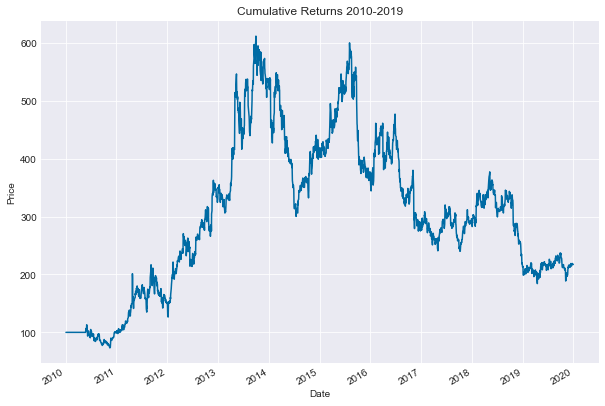

2010-2019
Portfolio cumulative returns:  217.32 %
Portfolio Profitability:  117.32 %


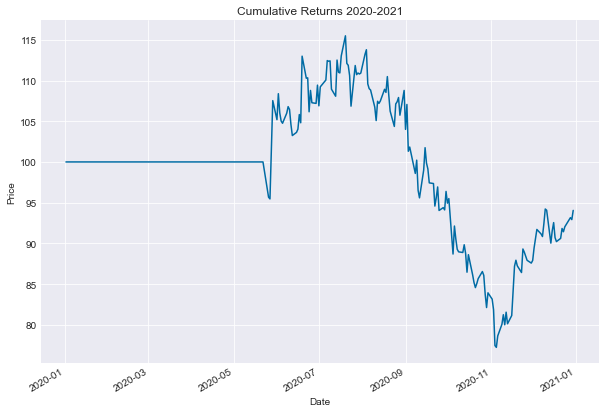

2020-2021
Portfolio cumulative returns:  94.05 %
Portfolio Profitability:  -5.95 %


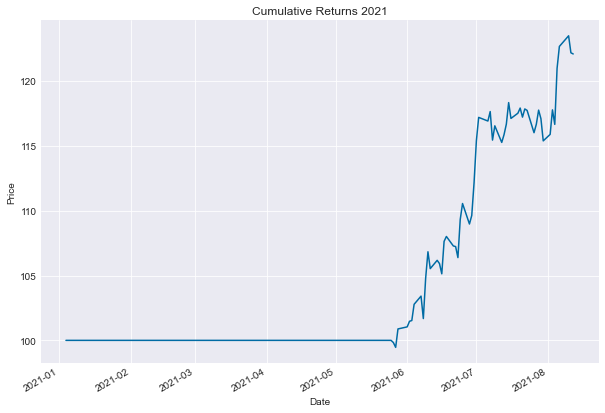

2021
Portfolio cumulative returns:  122.08 %
Portfolio Profitability:  22.08 %


In [19]:
#Создаем функцию, которая считает доходность портфеля (при применении стратегии)
def equity(dataset, title):
    
    # Считает разницу стоимости акций между двумя соседними днями
    dataset['returns'] = dataset['Close'].pct_change()

    # Считает доходность нашего портфеля при применении стратегии (ежедневно)
    dataset['strategy_returns'] = dataset['returns'] * dataset['positions'].shift(1)

    # Считаем и рисуем доходность нашего портфеля относительно начального объема вложений(учитываем за 100%)
    cumulative_returns = (dataset['strategy_returns'] + 1).cumprod()*100
    dataset['cumulative_returns'] = (dataset['strategy_returns'] + 1).cumprod()*100
    cumulative_returns = cumulative_returns.round(2)
    cumulative_returns.plot(figsize=(10, 7))
    plt.title('Cumulative Returns ' + title)
    plt.ylabel('Price')
    plt.show()
    
    print(title)
    print('Portfolio cumulative returns: ', cumulative_returns[-1], '%')
    # Считаем абсолютную доходность нашего портфеля
    print('Portfolio Profitability: ', np.round((cumulative_returns[-1] - 100), 2), '%')

# Применяем функцию
equity(train, '2010-2019')
equity(test, '2020-2021')
equity(final, '2021')

In [5]:
# Создаем функцию для подсчета необходимых для бэктеста показателей
def ratios(dataset, title):
    
    #Выгружаем данные по доходности 10-летних гос. облигаций США, принимая их за risk-free
    us_bonds_yield = yf.download('^TNX', start='2021-01-01', end='2021-08-13')
    us_bonds_yield = us_bonds_yield['Close'][-1]
    
    cumulative_returns = (dataset['strategy_returns'] + 1).cumprod()
    #Считаем risk-free rate за день (2520 - количество торговых дней за 10 лет)
    risk_free_rate = us_bonds_yield/2520

    # Считаем коэф. Шарпа ((доходность портфеля - доходность внерискового актива)/стандартное отклонение доходности портфеля)
    sharpe_ratio = np.sqrt(252)*(np.mean(dataset.strategy_returns) -
                       (risk_free_rate))/np.std(dataset.strategy_returns)
    print(title)
    # Оцениваем полученные значения коэф. Шарпа (<1 - плохо; >1 - хорошо)
    if sharpe_ratio > 1:
        print('Sharpe Ratio:     ', sharpe_ratio.round(2), '- GOOD') 
    else:
        print('Sharpe Ratio:     ', sharpe_ratio.round(2), '- BAD')
    # Считаем максимальное значение накопленной доходности портфеля
    running_max = np.maximum.accumulate(cumulative_returns.dropna())
    running_max[running_max < 1] = 1
    
    # Считаем максимальную просадку портфеля
    drawdown = (cumulative_returns)/running_max - 1
    max_drawdown = drawdown.min()*100
    print('Maximum drawdown: ', max_drawdown.round(2), '%')
    
    # Считаем отношение накопленной доходности к максимальной просадке
    drawdown_ratio = (cumulative_returns[-1]-1)*100/abs(max_drawdown)
    # Оцениваем полученные значения (<1 - плохо; >1 - хорошо(данная интрепретация является вольной - чем больше, тем лучше))
    if drawdown_ratio > 1:
        print('Drawdown Ratio:   ', drawdown_ratio.round(2), '- GOOD')
    else:
        print('Drawdown Ratio:   ', drawdown_ratio.round(2), '- BAD')

# Применяем функцию
ratios(train, '2010-2019')    
ratios(test, '2020-2021')
ratios(final, '2021')

[*********************100%***********************]  1 of 1 completed
2010-2019
Sharpe Ratio:      0.05 - BAD
Maximum drawdown:  -69.89 %
Drawdown Ratio:    1.68 - GOOD
[*********************100%***********************]  1 of 1 completed
2020-2021
Sharpe Ratio:      -0.57 - BAD
Maximum drawdown:  -33.13 %
Drawdown Ratio:    -0.18 - BAD
[*********************100%***********************]  1 of 1 completed
2021
Sharpe Ratio:      1.61 - GOOD
Maximum drawdown:  -2.5 %
Drawdown Ratio:    8.85 - GOOD


[*********************100%***********************]  1 of 1 completed


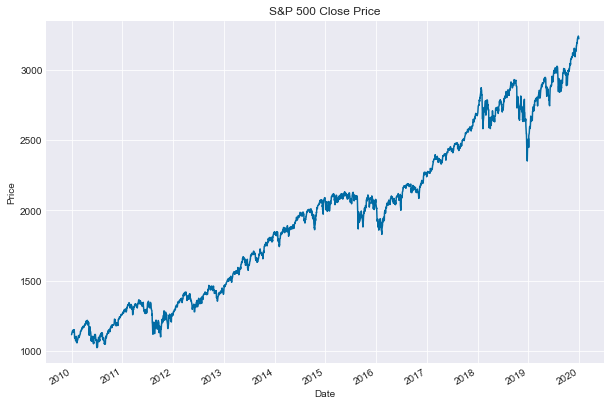

[*********************100%***********************]  1 of 1 completed


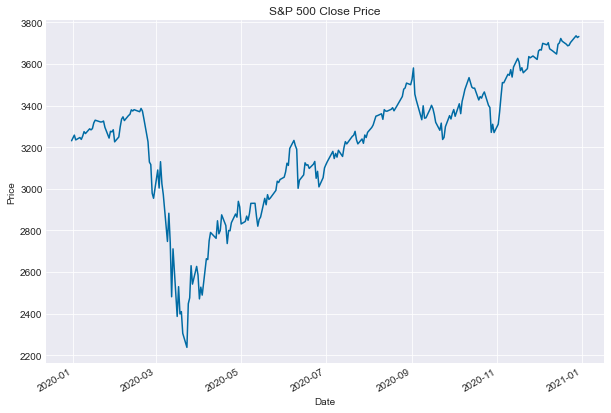

[*********************100%***********************]  1 of 1 completed


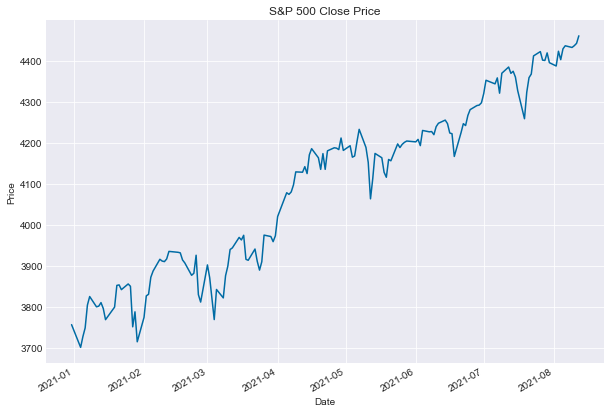

In [20]:
#Выгружаем данные с Yahoo Finance и строим график индекса S&P 500:
#За 10 лет
sp_train = yf.download('^GSPC', start='2010-01-01', end='2019-12-31')
sp_train['Close'].plot(figsize=(10,7))
plt.title('S&P 500 Close Price')
plt.ylabel('Price')
plt.show()

#За 2020 год
sp_test = yf.download('^GSPC', start='2020-01-01', end='2020-12-31')
sp_test['Close'].plot(figsize=(10,7))
plt.title('S&P 500 Close Price')
plt.ylabel('Price')
plt.show()

#С января по 13 августа 2021г.
sp_final = yf.download('^GSPC', start='2021-01-01', end='2021-08-13')
sp_final['Close'].plot(figsize=(10,7))
plt.title('S&P 500 Close Price')
plt.ylabel('Price')
plt.show() 

In [7]:
# Создаем функцию, которая считает доходность индекса за указанный период времени (без стратегии)
def SP500(dataset, title):
    
    returns = (dataset['Close'][-1]/dataset['Close'][0])*100
    
    print(title)
    print('S&P 500 cumulative returns\t', returns.round(2), '%')
    print('S&P 500 Profitability     \t', np.round((returns - 100), 2), '%')
    print('-'*54)

# Применяем функцию
SP500(sp_train, '2010-2019')    
SP500(sp_test, '2020-2021')    
SP500(sp_final, '2021')

2010-2019
S&P 500 cumulative returns	 288.88 %
S&P 500 Profitability     	 188.88 %
------------------------------------------------------
2020-2021
S&P 500 cumulative returns	 115.52 %
S&P 500 Profitability     	 15.52 %
------------------------------------------------------
2021
S&P 500 cumulative returns	 118.76 %
S&P 500 Profitability     	 18.76 %
------------------------------------------------------
